# [**Broutonlab**](https://broutonlab.com/) face recognition with masks pipeline

## [**github repo**](https://github.com/broutonlab/face-id-with-medical-masks) with solution

In [1]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Check GPU resources</font></b>
!nvidia-smi

Sat May 15 18:49:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Import requirements</font></b>
import os
import sys
import cv2
from matplotlib import pyplot as plt
import sys
import json
import numpy as np
import base64
from PIL import Image, ImageDraw


%matplotlib inline

In [3]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Clone and build face-alignment git repo</font></b>
!git clone https://github.com/1adrianb/face-alignment
%cd face-alignment
!pip install -r requirements.txt
!python setup.py install
import face_alignment

Cloning into 'face-alignment'...
remote: Enumerating objects: 1023, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 1023 (delta 22), reused 30 (delta 12), pack-reused 969
Receiving objects: 100% (1023/1023), 5.26 MiB | 41.11 MiB/s, done.
Resolving deltas: 100% (623/623), done.
/content/face-alignment
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating face_alignment.egg-info
writing face_alignment.egg-info/PKG-INFO
writing dependency_links to face_alignment.egg-info/dependency_links.txt
writing requirements to face_alignment.egg-info/requires.txt
writing top-level names to face_alignment.egg-info/top_level.txt
writing manifest file 'face_alignment.egg-info/SOURCES.txt'
a

In [4]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download and import face mask SDK</font></b>
!git clone https://github.com/broutonlab/face-id-with-medical-masks.git
%cd face-id-with-medical-masks

from masked_face_sdk.mask_generation_utils import \
(
    extract_target_points_and_characteristic, 
    extract_polygon,
    rotate_image_and_points,
    draw_landmarks,
    warp_mask,
    get_traingulation_mesh_points_indexes,
    end2end_mask_generation
)

Cloning into 'face-id-with-medical-masks'...
remote: Enumerating objects: 312, done.
remote: Total 312 (delta 0), reused 0 (delta 0), pack-reused 312
Receiving objects: 100% (312/312), 40.88 MiB | 38.02 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/face-alignment/face-id-with-medical-masks


In [5]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generate landmark estimator by face_alignment library</font></b>
# Generate landmark estimator by face_alignment library
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


-2.0475573276138643 0.9166257496037482


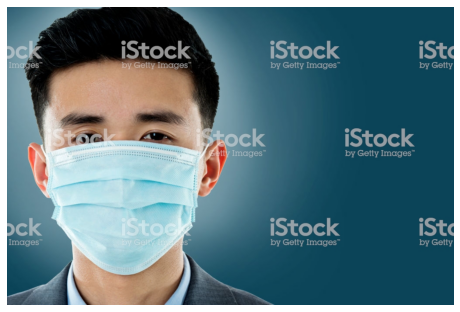

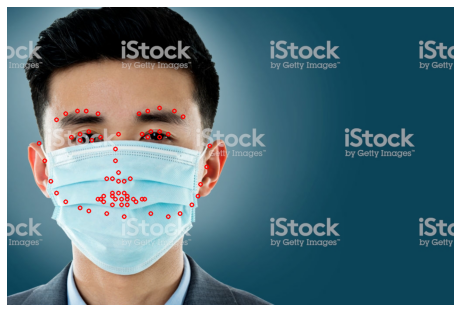

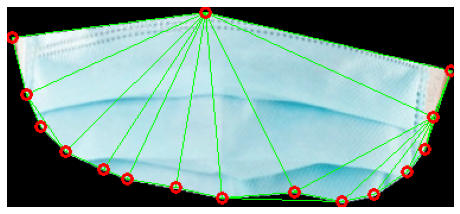

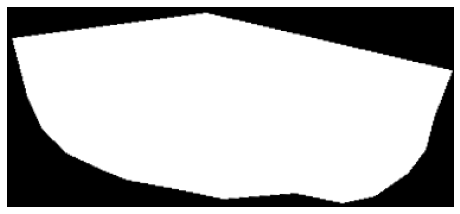

In [6]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Plot mask triangulation</font></b>
masked_faces_images_pathes = [
    os.path.join('data/masked_faces/', img_name)
    for img_name in os.listdir('data/masked_faces/')
]

example_image = cv2.cvtColor(
    cv2.imread(
        masked_faces_images_pathes[19]
    ), 
    cv2.COLOR_BGR2RGB
)

landmarks = fa.get_landmarks_from_image(example_image)
landmarks = np.floor(landmarks[0]).astype(np.int32)

plt.figure(figsize=(8, 8))
plt.imshow(example_image)
plt.axis('off')

plt.figure(figsize=(8, 8))
plt.imshow(draw_landmarks(example_image, landmarks, color=(255, 0, 0), thickness=4))
plt.axis('off')

target_points, s1, s2 = extract_target_points_and_characteristic(landmarks)
mask_rgba_crop, target_points = extract_polygon(example_image, target_points)

print(s1, s2)

mask_rgba_crop, target_points = rotate_image_and_points(mask_rgba_crop, s1, target_points)

triangles_indexes = get_traingulation_mesh_points_indexes(target_points)

mask_rgba_crop_vis = mask_rgba_crop[..., :3].copy().astype(np.uint8)
for triangle in triangles_indexes:
    triangle_points = target_points[triangle]
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[0]),
        tuple(triangle_points[1]),
        (0, 255, 0),
        1
    )
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[1]),
        tuple(triangle_points[2]),
        (0, 255, 0),
        1
    )
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[0]),
        tuple(triangle_points[2]),
        (0, 255, 0),
        1
    )

plt.figure(figsize=(8, 8))
plt.imshow(draw_landmarks(mask_rgba_crop_vis, target_points, color=(255, 0, 0), thickness=4))
plt.axis('off')

plt.figure(figsize=(8, 8))
plt.imshow(mask_rgba_crop[..., 3], 'gray')
plt.axis('off')


plt.show()

In [7]:
import os
os.getcwd()

'/content/face-alignment/face-id-with-medical-masks'

In [32]:
img_list=['data/tmy_passport2.jpg','data/tuto3_2.jpg','data/maha.jpg','data/smile.jpg','data/map.jpg']

In [33]:
def face_matching(test_img):
  #@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Face matching example</font></b>
  rows=1
  columns=3
  target_image = cv2.cvtColor(
      cv2.imread(
          test_img, 
          cv2.IMREAD_COLOR
      ),
      cv2.COLOR_BGR2RGB
  )

  landmarks2 = fa.get_landmarks_from_image(target_image)
  landmarks2 = np.floor(landmarks2[0]).astype(np.int32)

  target_points2, _, _ = extract_target_points_and_characteristic(landmarks2)

  target_image_with_mask = warp_mask(
      mask_rgba_crop[..., :3],
      target_image,
      target_points,
      target_points2
  )


  # triangles_indexes = get_traingulation_mesh_points_indexes(target_points2)

  mask_rgba_crop_vis = target_image_with_mask.copy().astype(np.uint8)
  for triangle in triangles_indexes:
      triangle_points = target_points2[triangle]
      
      mask_rgba_crop_vis = cv2.line(
          mask_rgba_crop_vis,
          tuple(triangle_points[0]),
          tuple(triangle_points[1]),
          (0, 255, 0),
          3
      )
    
      mask_rgba_crop_vis = cv2.line(
          mask_rgba_crop_vis,
          tuple(triangle_points[1]),
          tuple(triangle_points[2]),
          (0, 255, 0),
          3
      )
      
      mask_rgba_crop_vis = cv2.line(
          mask_rgba_crop_vis,
          tuple(triangle_points[0]),
          tuple(triangle_points[2]),
          (0, 255, 0),
          3
      )
  fig = plt.figure(figsize=(10, 7))
  fig.add_subplot(rows, columns, 1)
  plt.imshow(target_image)
  plt.axis('off')

  fig.add_subplot(rows, columns, 2)
  plt.imshow(draw_landmarks(mask_rgba_crop_vis, target_points2, color=(255, 0, 0), thickness=4))
  plt.axis('off')

  fig.add_subplot(rows, columns, 3)
  plt.imshow(target_image_with_mask)
  plt.axis('off')
  plt.show()

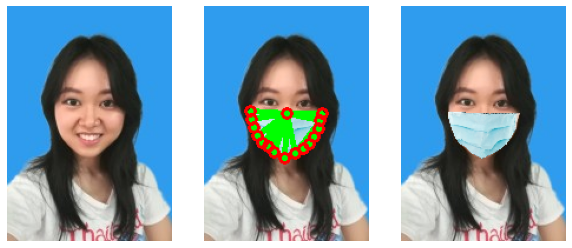

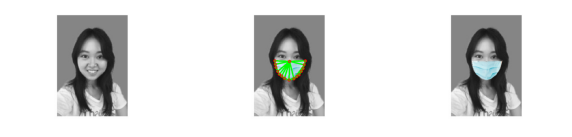

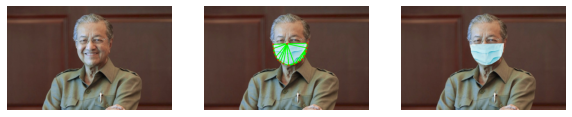

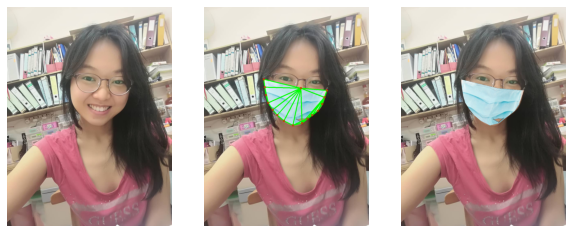

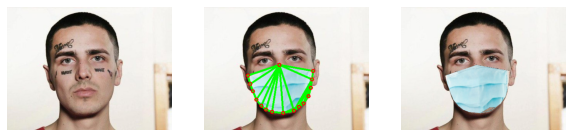

In [34]:
for img in img_list:
  face_matching(img)

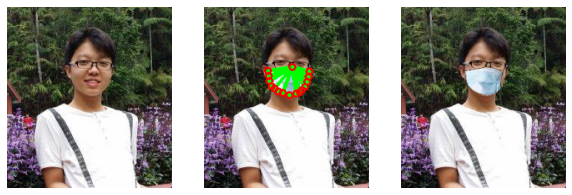

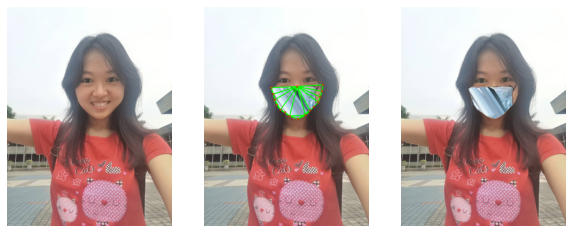

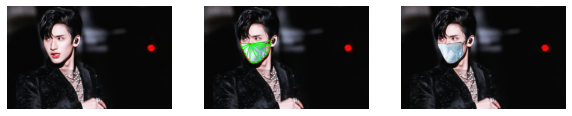

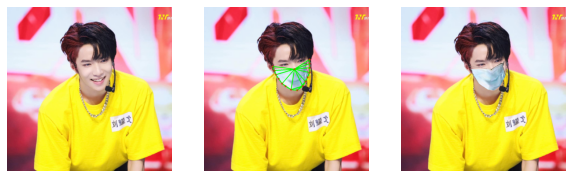

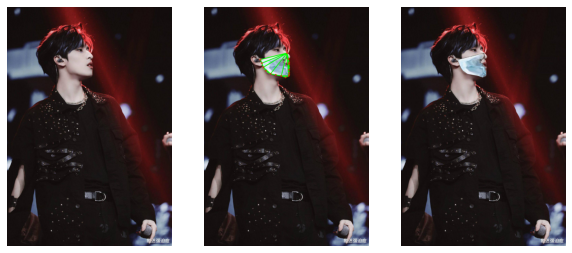

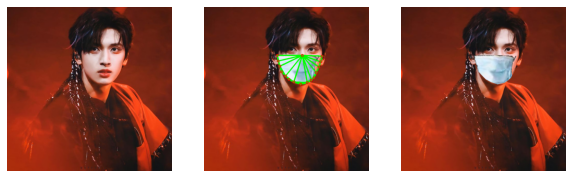

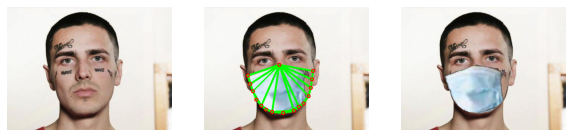

In [ ]:
for img in img_list:
  face_matching(img)

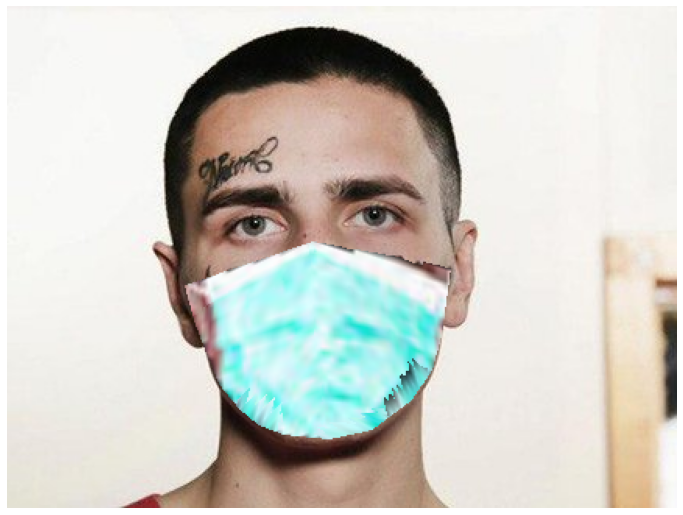

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download database and plot the results</font></b>
with open('data/masks_base.json', 'r') as jf:
    masks_database = json.load(jf)
target_image_with_mask = end2end_mask_generation(target_image, masks_database, fa)

plt.figure(figsize=(12, 12))
plt.imshow(target_image_with_mask)
plt.axis('off')
plt.show()